In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

/home/sebastian/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Manually labeled data

In [2]:
data = pd.read_csv('SB_interpretation_data.csv')

The dataset has the following columns:

- **url**: url of the news article.
- **outlet**: media outlet
- **SB**: [Sentiment Bias](https://arxiv.org/abs/2310.08701) of the news article.
- **id**: id of the news article,
- **RC...**: Researcher Classication. Manual classification if the article is positive, negative, or neutral respect to a political coalition (Center-Left or Center-Right). This classication was independently made by 6 researchers.
- **Overall...**: Mayority rule applied over the previous classifications. If an article was equally labeled as positive, negative or neutral by researches, we considered as a neutral article.
- **SB_labeled**: Tendency of the article based on Overall Position classification. -1 means positive (favorable) to CL and/or negative to CR; 0 means neutral, positive or negative to both coalitions; 1 means positive (favorable) to CR and/or negative to CL. For insntace, if an article is classified as positive to Center-Left (Overall_Position_CL = 1) and negative to Center-Right (Overall_Position_CR = -1), SB_labeled = -1.

In [3]:
data.head(n = 5)

,url,outlet,SB,id,RC1_Position_CL,RC1_Position_CR,RC2_Position_CL,RC2_Position_CR,RC3_Position_CL,RC3_Position_CR,RC4_Position_CL,RC4_Position_CR,RC5_Position_CL,RC5_Position_CR,RC6_Position_CL,RC6_Position_CR,Overall_Position_CL,Overall_Position_CR,SB_labeled
0,https://www.eldestapeweb.com/las-disparatadas-...,El Destape,0.0,-7173905428650727075,0,0,1,-1,1,-1,0,0,1,0,-1,0,1,0,-1.0
1,https://www.lanacion.com.ar/lifestyle/juan-jos...,La Nacion,0.5,6691367890423479122,-1,0,-1,0,-1,0,0,0,0,0,0,0,-1,0,1.0
2,https://www.minutouno.com/politica/elecciones-...,Minuto Uno,0.0,-8216454734361956032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
3,https://www.eldia.com/nota/2019-6-23-5-32-13-p...,El Dia,0.2,7427220706995217092,0,0,0,0,0,-1,0,0,0,0,0,0,0,0,0.0
4,https://www.pagina12.com.ar/193581-la-salud-ca...,Pagina 12,-1.0,6652492314270594207,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,0,-1,-1.0


### Logistic Regression for interpretation 

To interpret what the **SB** value means, we try to predict the **SB_labeled** columns by a logistic regression with the **SB** as the unique variable. 

In [4]:
from sklearn.linear_model import LogisticRegression

# Model
logreg = LogisticRegression(penalty=None, fit_intercept=False)

# Data
X = data['SB'].to_numpy().reshape(-1,1)
y = data['SB_labeled'].to_numpy()

# Fit of the model
logreg.fit(X, y)

LogisticRegression(fit_intercept=False, penalty=None)

In [5]:
print('Model coefficients: ', logreg.coef_.ravel())

Model coefficients:  [-0.88464397 -0.37397946  1.25862343]


#### Probability of being favorable or neutral to each coalition:

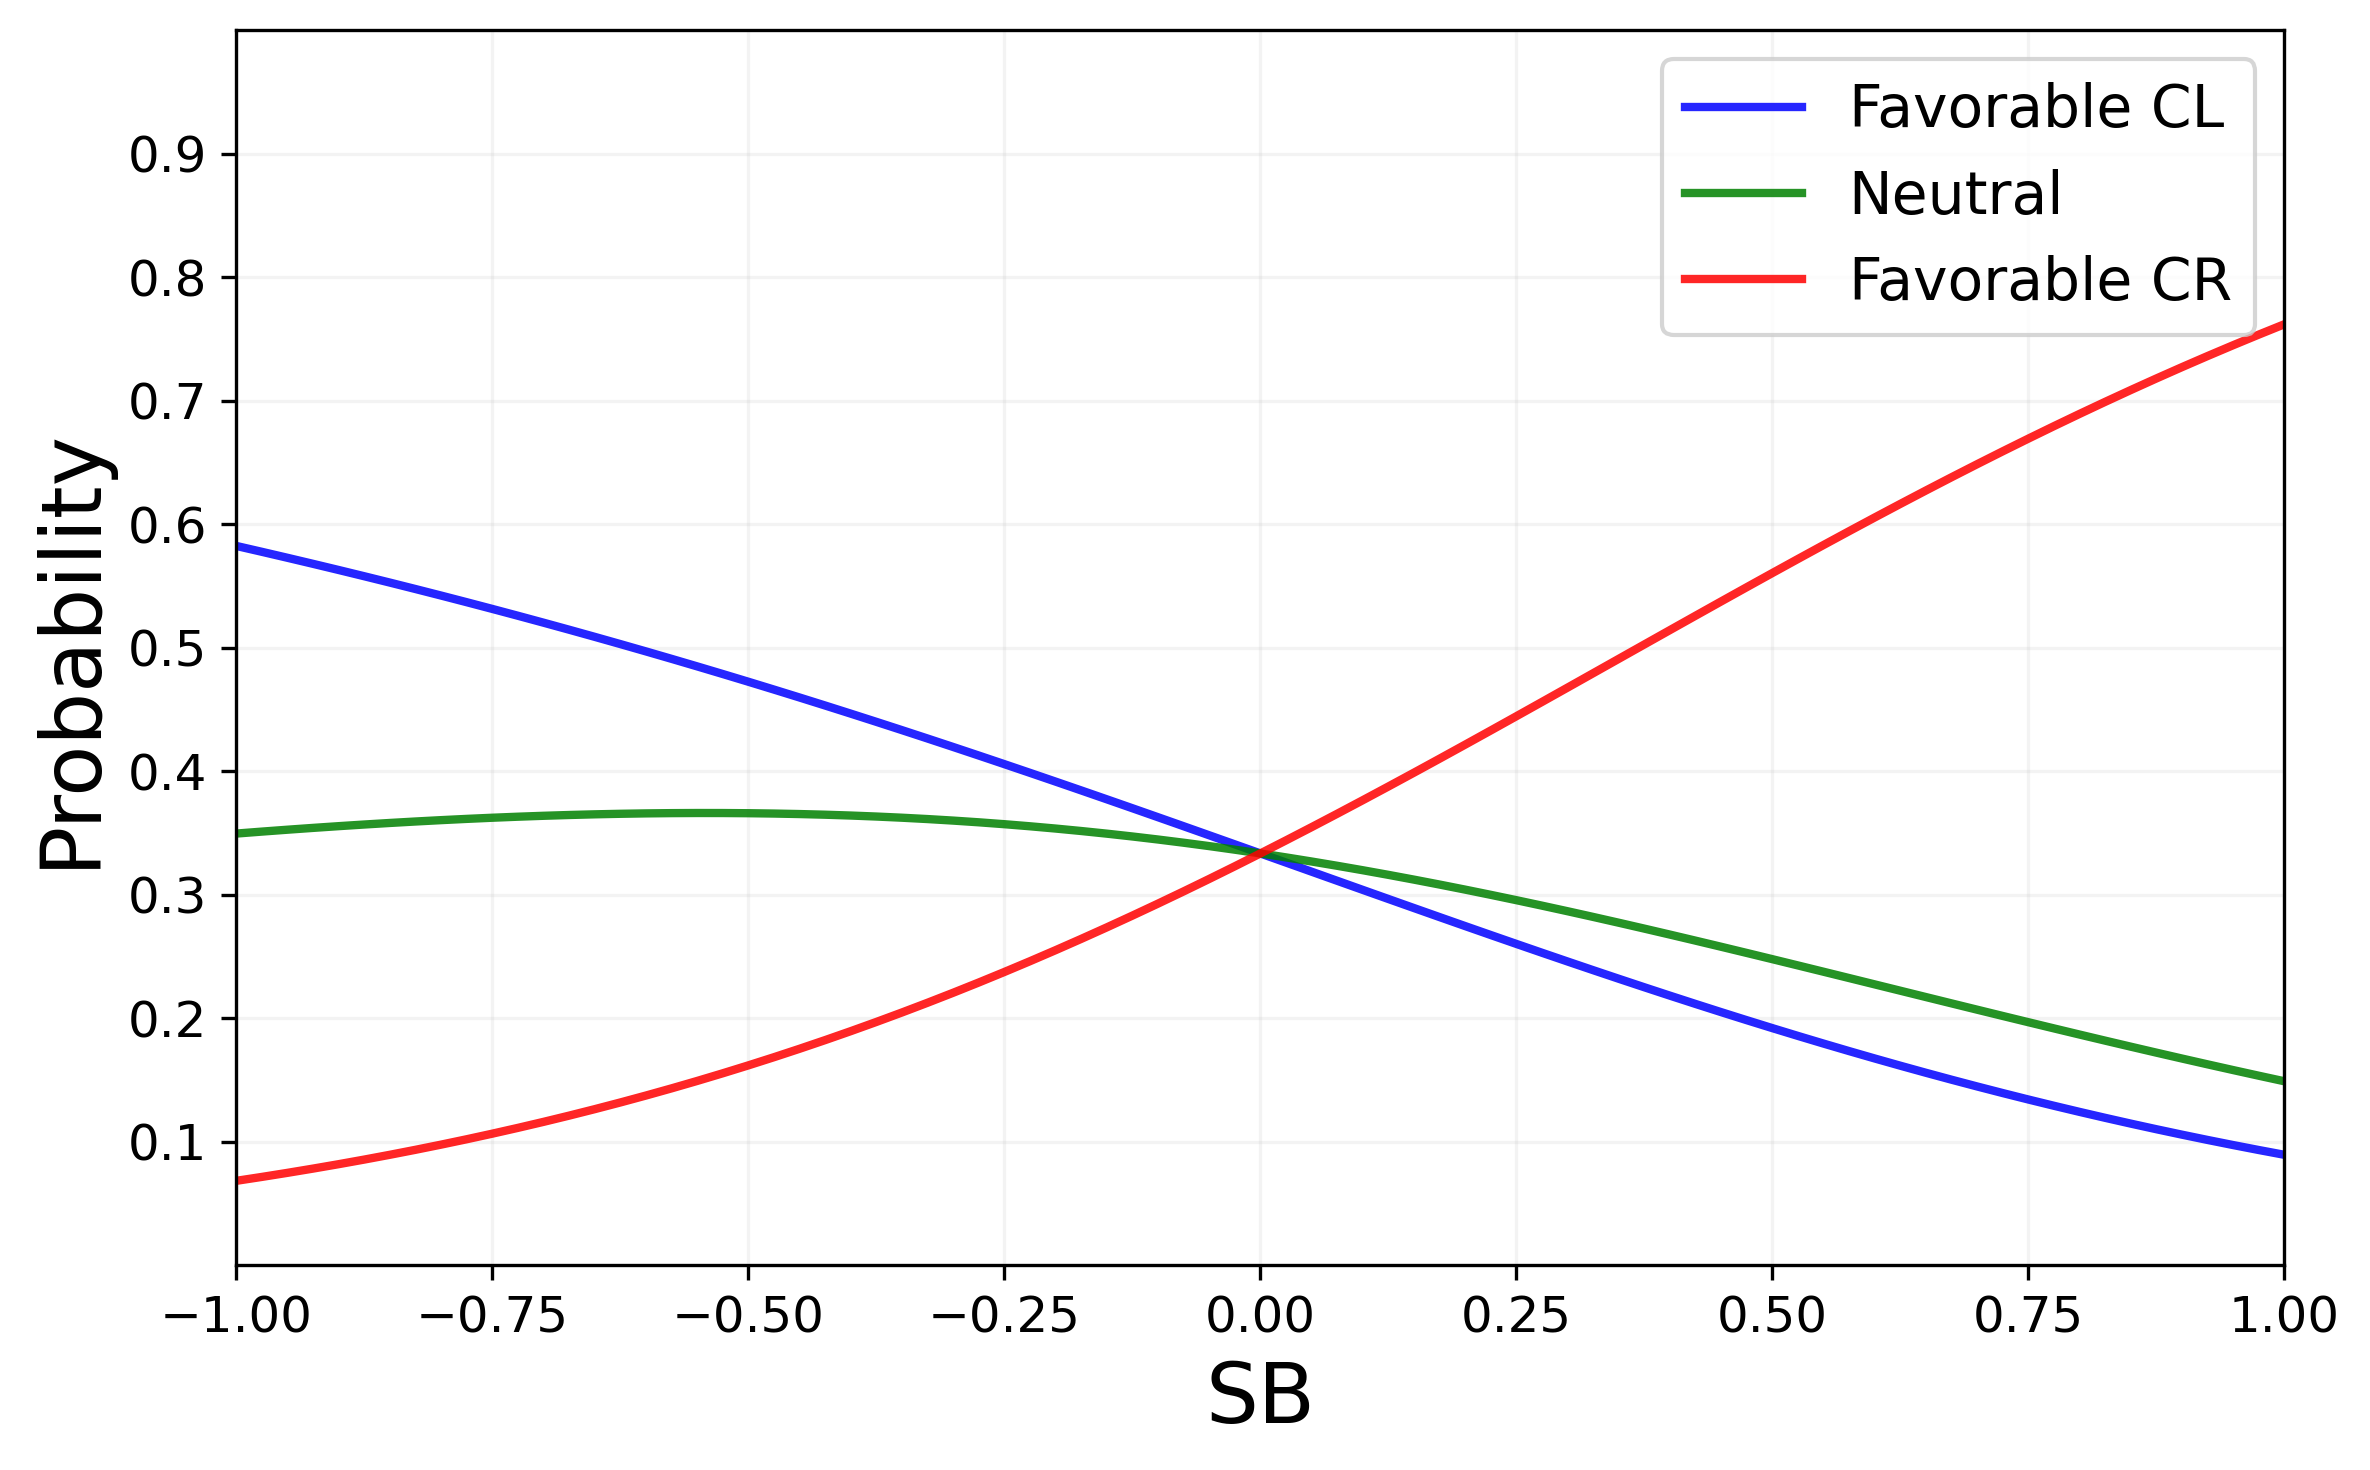

In [6]:
xrange = np.arange(-1, 1.01, 0.025)
estimated_probas = logreg.predict_proba([[i] for i in xrange])

plt.figure(figsize = (8,5), dpi = 300)
plt.plot(xrange, estimated_probas[:,0], linewidth = 2, alpha = 0.85, color = 'b', label = 'Favorable CL')
plt.plot(xrange, estimated_probas[:,1], linewidth = 2, alpha = 0.85, color = 'g', label = 'Neutral')
plt.plot(xrange, estimated_probas[:,2], linewidth = 2, alpha = 0.85, color = 'r', label = 'Favorable CR')

plt.grid(True, alpha = 0.15)
plt.legend(loc= 'best', fontsize = 14)
plt.xlabel('SB', size = 20)
plt.ylabel('Probability', size = 20)
plt.yticks(np.arange(0.10, 0.91, 0.10), ['{:1.1}'.format(i) for i in np.arange(0.10, 0.91, 0.10)], size = 12)
plt.xticks(size = 12)
plt.ylim([0,1])
plt.xlim([-1, 1])
plt.tight_layout()
plt.show()

#### Error of the model

Fluctuations estimated with bootstrapping. 

In [7]:
# Function to fit the model to resampled data
def probas_bootstrap(data):

    logreg = LogisticRegression(penalty=None, fit_intercept=False)

    probas = []
    coeffs = []
    for iteration in range(1000):
        
        sample = data.sample(n = data.shape[0], replace = True)
        
        X = sample['SB'].to_numpy().reshape(-1,1)
        y = sample['SB_labeled'].to_numpy()
        
        logreg.fit(X, y)
        
        xrange = np.arange(-1, 1.01, 0.025)
        
        probas.append(logreg.predict_proba([[i] for i in xrange]))
        coeffs.append(logreg.coef_.ravel())
        
    return np.array(probas), np.array(coeffs)

# Probabilities and coefficents per bootstrapping iteration
probas, coeffs = probas_bootstrap(data)

In [8]:
# 90% quantiles
quantiles = np.quantile(probas, axis = 0, q = [0.05, 0.95])

sb_neg_qi = quantiles[0].T[0]
sb_neg_qs = quantiles[1].T[0]

sb_neu_qi = quantiles[0].T[1]
sb_neu_qs = quantiles[1].T[1]

sb_pos_qi = quantiles[0].T[2]
sb_pos_qs = quantiles[1].T[2]

Figure:

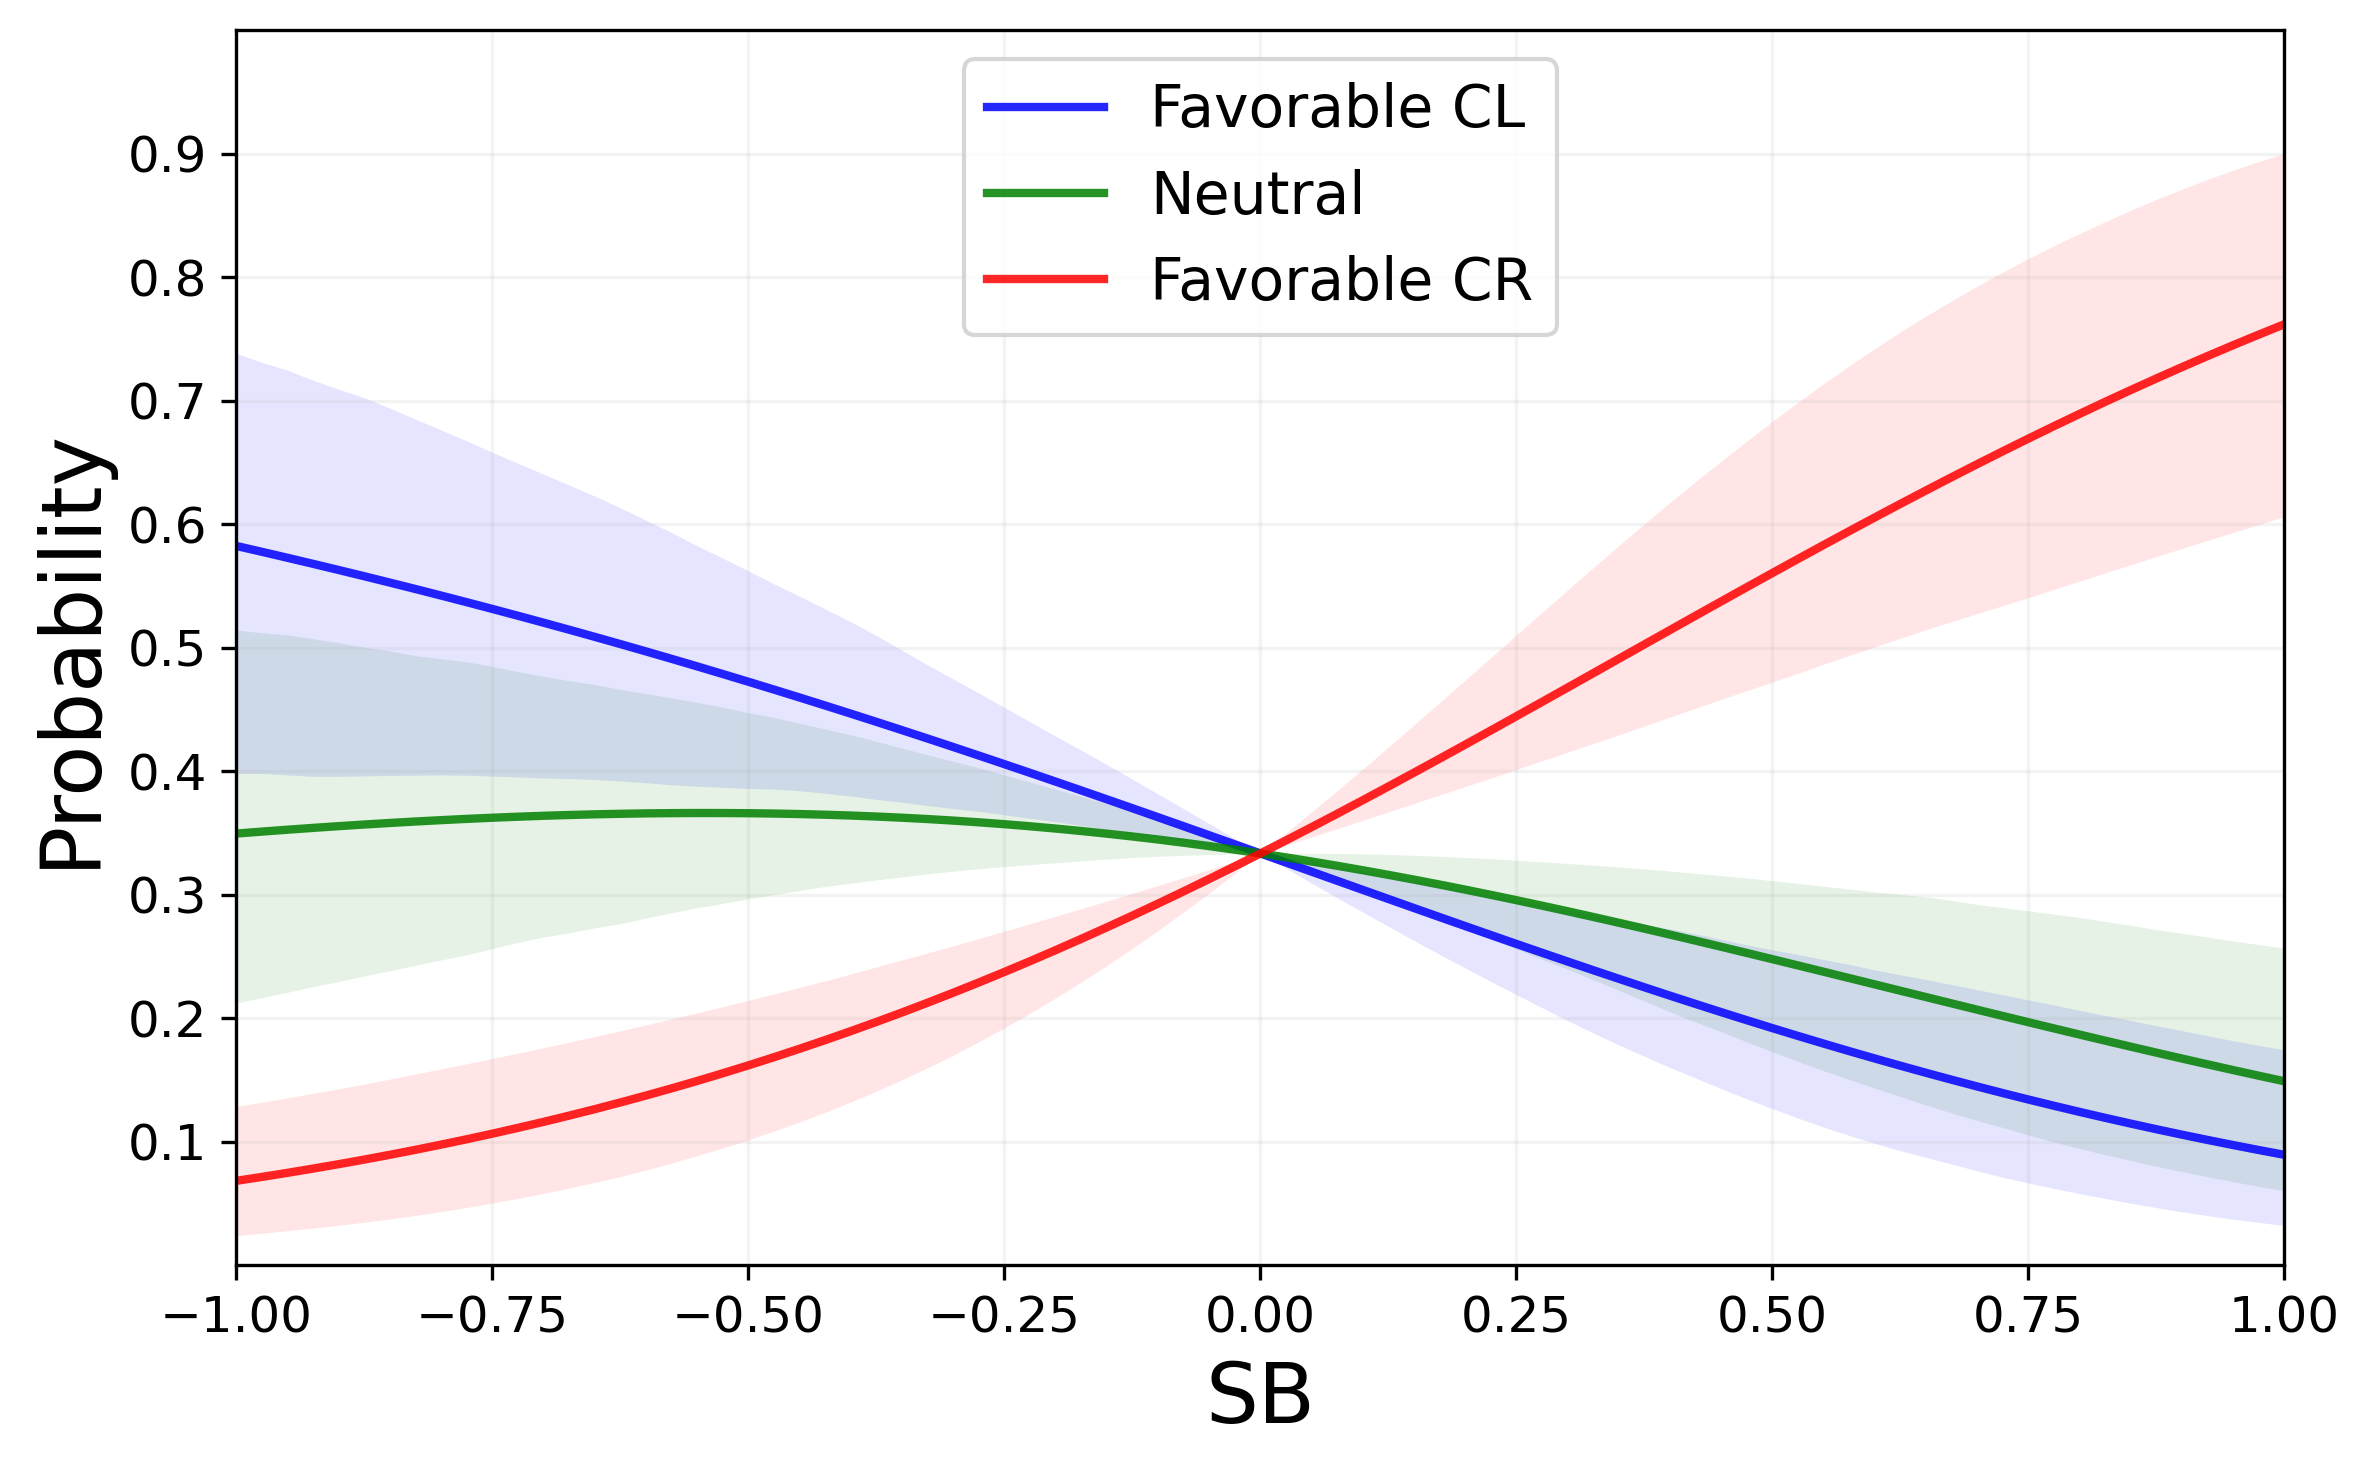

In [9]:
plt.figure(figsize = (8,5), dpi = 300)
plt.plot(xrange, estimated_probas[:,0], linewidth = 2, alpha = 0.85, color = 'b', label = 'Favorable CL')
plt.plot(xrange, estimated_probas[:,1], linewidth = 2, alpha = 0.85, color = 'g', label = 'Neutral')
plt.plot(xrange, estimated_probas[:,2], linewidth = 2, alpha = 0.85, color = 'r', label = 'Favorable CR')

plt.fill_between(xrange, y1=sb_neu_qi, y2=sb_neu_qs, alpha = 0.10, color = 'g', linewidth = 0)
plt.fill_between(xrange, y1=sb_pos_qi, y2=sb_pos_qs, alpha = 0.10, color = 'r', linewidth = 0)
plt.fill_between(xrange, y1=sb_neg_qi, y2=sb_neg_qs, alpha = 0.10, color = 'b', linewidth = 0)

plt.grid(True, alpha = 0.15)
plt.legend(loc= 'upper center', fontsize = 14)
plt.xlabel('SB', size = 20)
plt.ylabel('Probability', size = 20)
plt.yticks(np.arange(0.10, 0.91, 0.10), ['{:1.1}'.format(i) for i in np.arange(0.10, 0.91, 0.10)], size = 12)
plt.xticks(size = 12)
plt.ylim([0,1])
plt.xlim([-1, 1])
plt.tight_layout()
plt.savefig('SB_interpretation_with_errors.pdf')
plt.show()

Coefficients 90% intervals: 

In [10]:
np.quantile(coeffs, q = [0.05, 0.95], axis = 0)

array([[-1.44512999, -0.87681795,  0.79414098],
       [-0.41468395,  0.02524876,  1.97228761]])